COPY/PASTE FOR STARTER README:

## Problem Statement/Goal
 - Pull insights and see what I can do to predict a change.
 
 People who did the most sessions preferred which method?
 What other habits were formed by using more of the app?
 
Marajuana might be a great way for people to treat depression, anxiety and stress, at least in the short term before finding more sustainable and longterm solutions.  If one could build a model which could predict the potential change for a consumer, then a company might then be able to reccomend targeted suggestions for a specific customer based on what would be most effective and helpful for them.
 
 
 To Do:
  - Clean up EDA
  - Clean up what we have of the modeling done
  - Address the combining of the three models
  - Work on the Neural Network

### POTENTIAL PIPELINE FUNCTIONS 
 - Reg Metrics/Classification Metrics
 - Model Cleaning
     - Nan's
     - Likely inaccurate Outliers
     - Seperating model df from insight/human df
 - EDA
     - Return basic df info (Nan's, describe, shape)
     - Function to instantly sort and return: duscreet categorical rows as bar charts, continuous & large ones as histograms, counts and things like violine/box plots
     - Will drop unneeded columns (catigorical & binary) and then return bestest sns.pairplot
     - Imporant correlations heatmap
 - Model Prep
     - T/T Split w/ just inserting df & target
     - Dummies
     - Scaling
 - Feature Engineering
     - Poly (& div & add * subtract)??
     - Multiplicable Dummies
     - Save Feature Parameters in csv file & update
     - return features from trees
     - Aggregate observations/features: purchases_over_last_30_days
     - from scipy.stats import rankdata? or Log Transformation: np.log(1 + x)
     - Numeric to categorical mappings/Binning/Label Encoding
     - Return PCA w/real info
 - Model Running
     - Test literally all models
     - Model fit/predict
     - Model Gridsearching easier and/or make my own???
     - K-folds CV
 - Post-model
     - Visualize model information
     - Visualize NN Results/info
     - Save model results
     - Error analysis
     - VISUALIZE A FUNTIONING DECISION TREE
     - Return Gridsearch results visualized

## Imports

In [2]:
# Standard & quality of life imports
import pandas as pd   #loc[row_indexer,col_indexer]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from time import time
from datetime import datetime
%matplotlib inline

# Model prep & metric imports
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, Normalizer#, Binarizer
from sklearn.decomposition import PCA

# Regression model imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

# Neural Network Imports
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking, Embedding
from keras import backend

df = pd.read_csv('./data/all_symptoms_cleaned.csv')

/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorF

Couldn't import dot_parser, loading of dot files will not be possible.


## Defining useful functions

In [82]:
# Quality of life
def now():
    return datetime.fromtimestamp(time()).strftime('%m/%d/%Y, %H:%M:%S')

'08/07/2019, 09:30:04'

In [3]:
# For general ease.
def Reg_metrics(y_real, y_hat):
    print('RMSE            :',np.sqrt(metrics.mean_squared_error(y_real, y_hat)))   # Goal=0, Avg Distance
    print('Median Abs Error:',metrics.median_absolute_error(y_real,y_hat))          # Goal=0, Median Distance
    print('R Squared       :',metrics.r2_score(y_real, y_hat))          # Goal=1, Percent model can explain
    return

# Used in Neural Network
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

df_results = pd.DataFrame(columns=['model', 'features', 'parameters',
    'train_RMSE', 'train_Median_error', 'train_R_squared',
    'test_RMSE',  'test_Median_error',  'test_R_squared', 'time'])

def run_model(model, X_train, X_test, y_train, y_test, results_dataframe, save = True, 
              rando_state = 76, is_neural_network = False, 
              NN_epochs = 10, NN_batch_size = 32, NN_verbose = 0):

    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rando_state)

    if is_neural_network == False:
        # Performing normal running of model.
        model      = model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : re.findall(r'^[^@]+\(', str(model))[0].strip("("),
                 'parameters' : model.get_params()}
        
    elif is_neural_network == True:
        # Running model for Neural Networks
        X_train = [X_train[col].as_matrix() for col in X_train.columns]
        X_test  = [X_test[col].as_matrix() for col in X_test.columns]
        results = model.fit(X_train, y_train, 
                    epochs= NN_epochs, 
                    batch_size = NN_batch_size,
                    verbose = NN_verbose,
                    validation_data = (X_test,y_test))
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : "Neural Network",
                 'parameters' : {'layers' : [layer.get_config()['units'] for layer in results.model.layers],
                                 'batch_size' : NN_batch_size,
                                 'epochs'     : NN_epochs}}

    else:
        print("A non-boolian value was passed to is_neural_network.  This is an error.")
        return
    
    # Adding non-model dependant information to dict_model
    dict_model['time']               = 
    dict_model['features']           = [feature for feature in X.columns]
    dict_model['train_RMSE']         = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    #dict_model['train_Median_error'] = metrics.median_absolute_error(y_train, pred_train)
    #dict_model['train_R_squared']    = metrics.r2_score(y_train, pred_train)
    dict_model['test_RMSE']          = np.sqrt(metrics.mean_squared_error(y_test, pred_test))

    # Saving current results
    results_dataframe = results_dataframe.append(dict_model, ignore_index=True)
    if save == True:
        results_dataframe.to_csv('./data/modeling_results_' + datetime.fromtimestamp(time()).strftime('%m_%d_%Y')
                          , index = False)
    
    return results_dataframe

In [ ]:
def save_results(df):
    results_dataframe.to_csv('./data/modeling_results_' + datetime.fromtimestamp(time()).strftime('%m_%d_%Y')
                          , index = False)
    return

In [83]:
dict_model = {'model' : re.findall(r'^[^@]+\(', str(model))[0].strip("("),
                 'parameters' : model.get_params()}

NameError: name 'model' is not defined

In [3]:
# For general ease.
def RMSE(y_real, y_hat):
    return np.sqrt(metrics.mean_squared_error(y_real, y_hat))

# Used in Neural Network
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

df_results = pd.DataFrame(columns=['model', 'features', 'parameters',
    'train_RMSE', 'train_Median_error', 'train_R_squared',
    'test_RMSE',  'test_Median_error',  'test_R_squared', 'time'])

def run_model(model, X_train, X_test, y_train, y_test, results_dataframe, save = True, 
              rando_state = 76, is_neural_network = False, 
              NN_epochs = 10, NN_batch_size = 32, NN_verbose = 0):

    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rando_state)

    if is_neural_network == False:
        # Performing normal running of model.
        model      = model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : re.findall(r'^[^@]+\(', str(model))[0].strip("("),
                 'parameters' : model.get_params()}
        
    elif is_neural_network == True:
        # Running model for Neural Networks
        X_train = [X_train[col].as_matrix() for col in X_train.columns]
        X_test  = [X_test[col].as_matrix() for col in X_test.columns]
        results = model.fit(X_train, y_train, 
                    epochs= NN_epochs, 
                    batch_size = NN_batch_size,
                    verbose = NN_verbose,
                    validation_data = (X_test,y_test))
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : "Neural Network",
                 'parameters' : {'layers' : [layer.get_config()['units'] for layer in results.model.layers],
                                 'batch_size' : NN_batch_size,
                                 'epochs'     : NN_epochs}}

    else:
        print("A non-boolian value was passed to is_neural_network.  This is an error.")
        return
    
    # Adding non-model dependant information to dict_model
    dict_model['time']               = datetime.fromtimestamp(time()).strftime('%m/%d/%Y, %H:%M:%S')
    dict_model['features']           = [feature for feature in X.columns]
    dict_model['train_RMSE']         = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    #dict_model['train_Median_error'] = metrics.median_absolute_error(y_train, pred_train)
    #dict_model['train_R_squared']    = metrics.r2_score(y_train, pred_train)
    dict_model['test_RMSE']          = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    #dict_model['test_Median_error']  = metrics.median_absolute_error(y_test, pred_test)
    #dict_model['test_R_squared']     = metrics.r2_score(y_test, pred_test)
    
    # Printing current results
    print(dict_model['model'] + ' Train')
    print('RMSE : ' + str(dict_model['train_RMSE']))
    #print('Median Abs Error : ' + str(dict_model['train_Median_error']))
    #print('R Squared        : ' + str(dict_model['train_R_squared']))
    print('\n' + dict_model['model'] + ' Test')
    print('RMSE : ' + str(dict_model['test_RMSE']))
    #print('Median Abs Error : ' + str(dict_model['test_Median_error']))
    #print('R Squared        : ' + str(dict_model['test_R_squared']))
    
    # Saving current results
    results_dataframe = results_dataframe.append(dict_model, ignore_index=True)
    if save == True:
        results_dataframe.to_csv('./data/modeling_results_' + datetime.fromtimestamp(time()).strftime('%m_%d_%Y')
                          , index = False)
    
    return results_dataframe

In [ ]:
# EDA

def pairplot_print(df):
    return sns.pairplot(df.drop([col for col in df.columns if len(df[col].unique()) <= 2], axis = 1))

# Cleaning DF

In [419]:
# Importing the data
df_anxiety = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='anxiety')
df_depression = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='depression')
df_stress = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='stress')

In [336]:
df.rename({
    'session/time'              : 'session', # As in Session #1 or Session #2 or Session #3 for a user.
    'time lag (min)'            : "time_lag",# Time it took from initial ingestion to when effects were tracked
    '% thc'                     : 'thc_%', 
    '% cbd'                     : 'cbd_%',
    'admin_method_Concentrate'  : 'concentrate',
    'admin_method_Dab Bubbler'  : 'dab_bubbler',
    'admin_method_Dab Portable' : 'dab_portable',
    'admin_method_Smoke'        : 'smoke',
    'admin_method_Vape'         : 'vape',
    'symptom_anxiety'           : 'symptom_a',
    'symptom_depression'        : 'symptom_d',
    'symptom_stress'            : 'symptom_s',
    'admin_method'              : 'method'
}, axis = 1, inplace = True)

# Saving for safety and to make sure that this is always up to date.
df.to_csv('./data/all_symptoms_cleaned.csv', index=False)

In [17]:
def split_df(df):
    df_robot = pd.get_dummies(df)
    df_human = df
    return df_robot, df_human
test_df_ro, test_df_hu = split_df(df)#, ['method', 'symptom'])

In [74]:
def tell_us(df):
    info_df          = df.describe().T
    info_df['Nans']  = [df[inx].isna().sum() for inx in info_df.index]
    info_df['dtype'] = [df[inx].dtype for inx in info_df.index]
    print(df.shape)
    #print(df.memory_usage().sum(), 'bits')
    return info_df

In [9]:
print('Number of users in study:', len(df['userid'].value_counts())) # (Post data cleaning)

Number of users in study: 1062


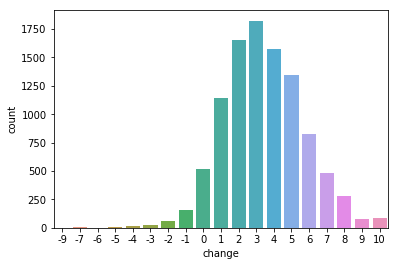

In [10]:
sns.countplot(df['change']);

In [77]:
for col in df.columns:
    if len(df[col].unique()) <= 2:
        print(col)

gender
concentrate
dab_bubbler
dab_portable
smoke
vape
symptom_a
symptom_d
symptom_s


In [78]:
[col for col in df.columns if len(df[col].unique()) <= 2]

['gender',
 'concentrate',
 'dab_bubbler',
 'dab_portable',
 'smoke',
 'vape',
 'symptom_a',
 'symptom_d',
 'symptom_s']

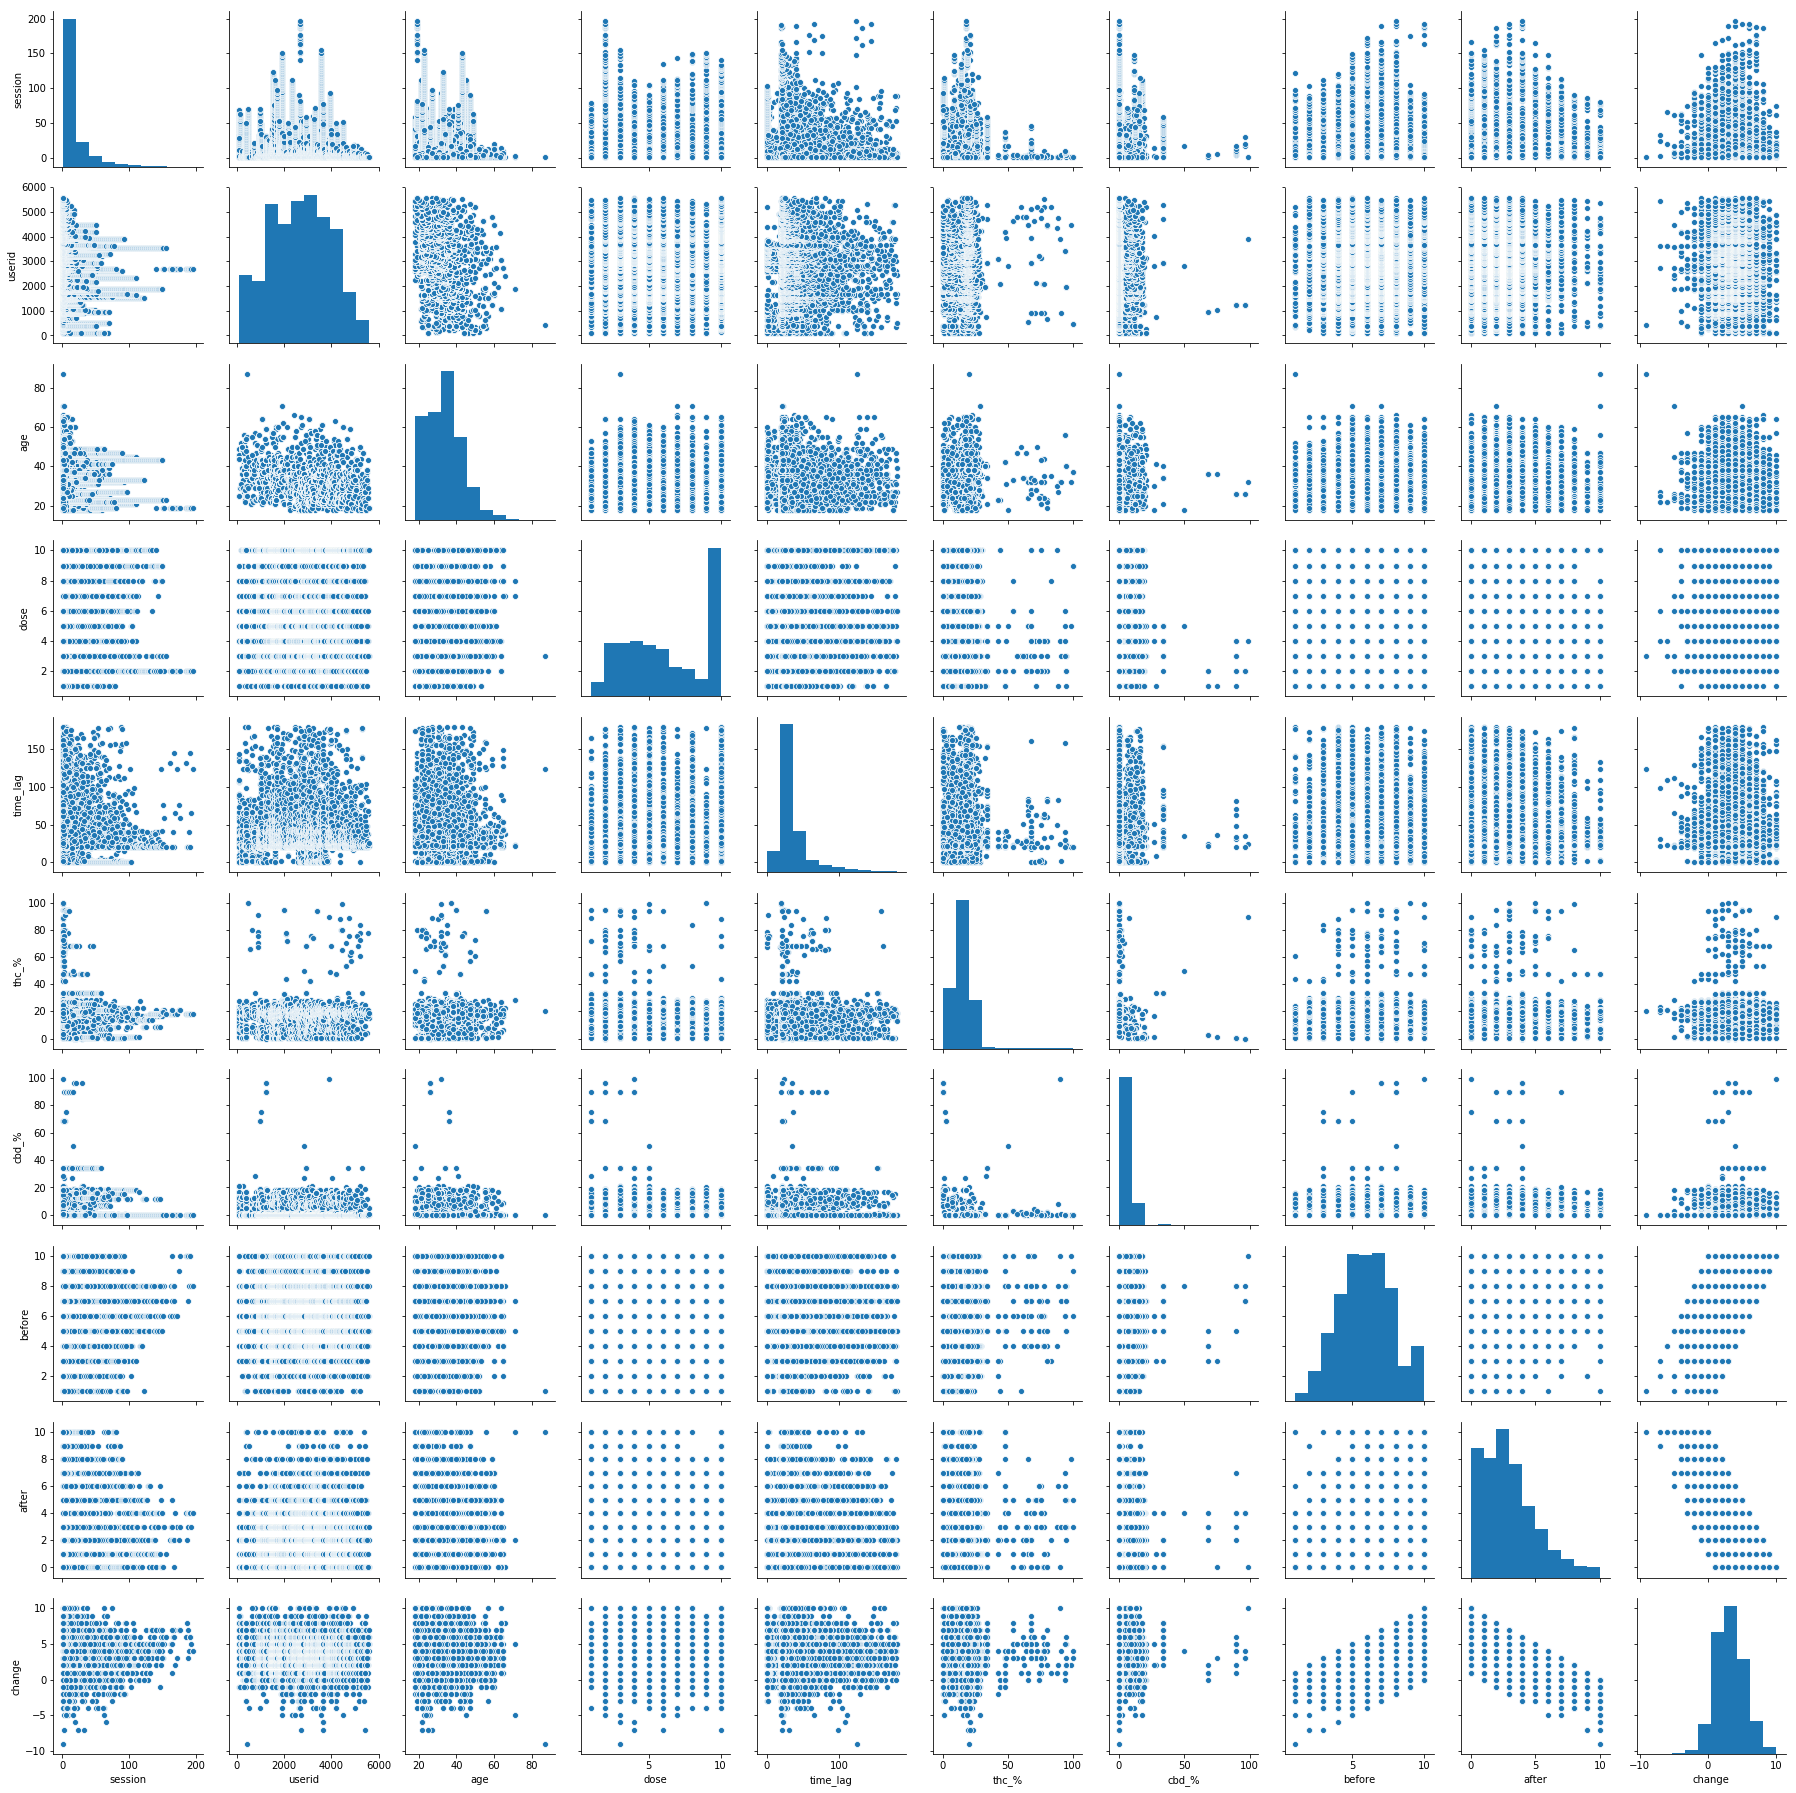

In [81]:
# Shortening the df to only the numerical data of note.
def pairplot_print(df):
    return sns.pairplot(df.drop([col for col in df.columns if len(df[col].unique()) <= 2], axis = 1))


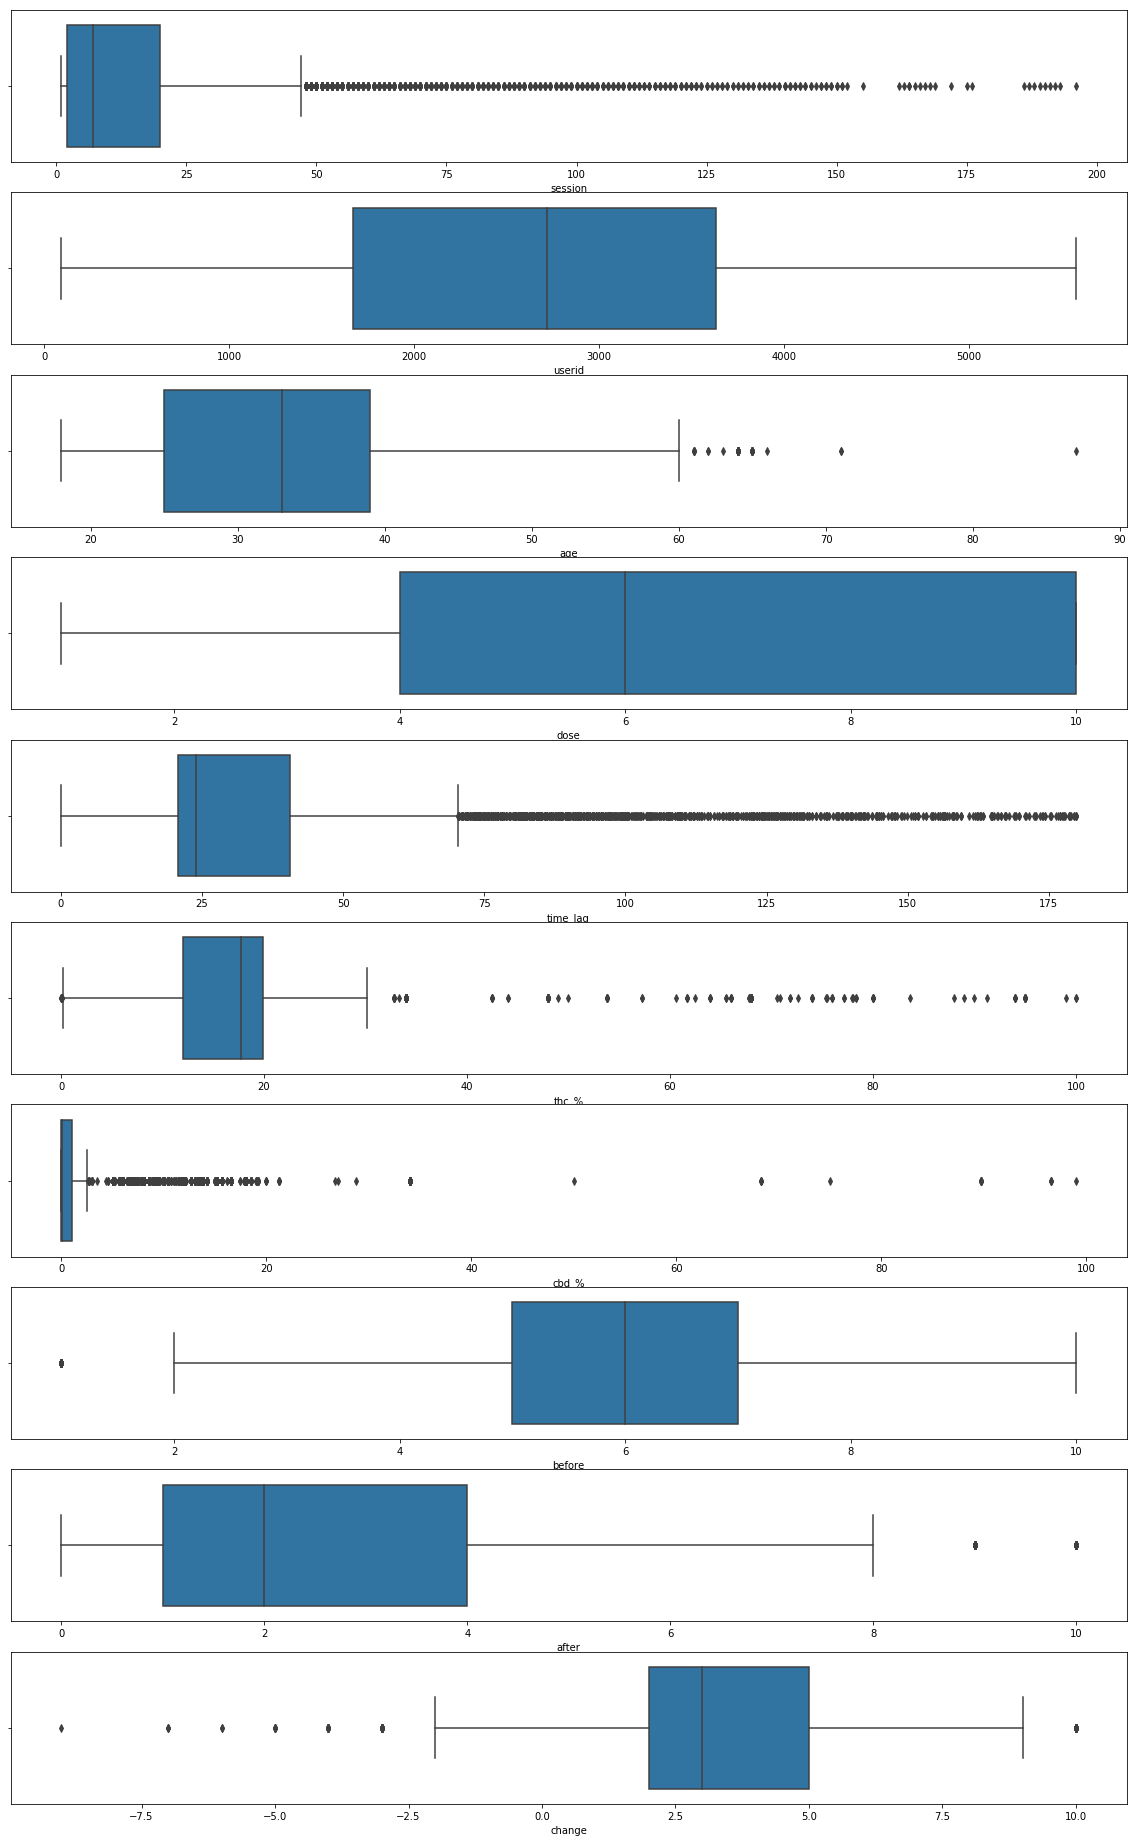

In [12]:
fig, axes = plt.subplots(len(df_short.columns),     
                   figsize = (20,33)) # Size
count = 0
for col in df_short.columns:
    sns.boxplot(df_short[col], ax = axes[count])
    count += 1

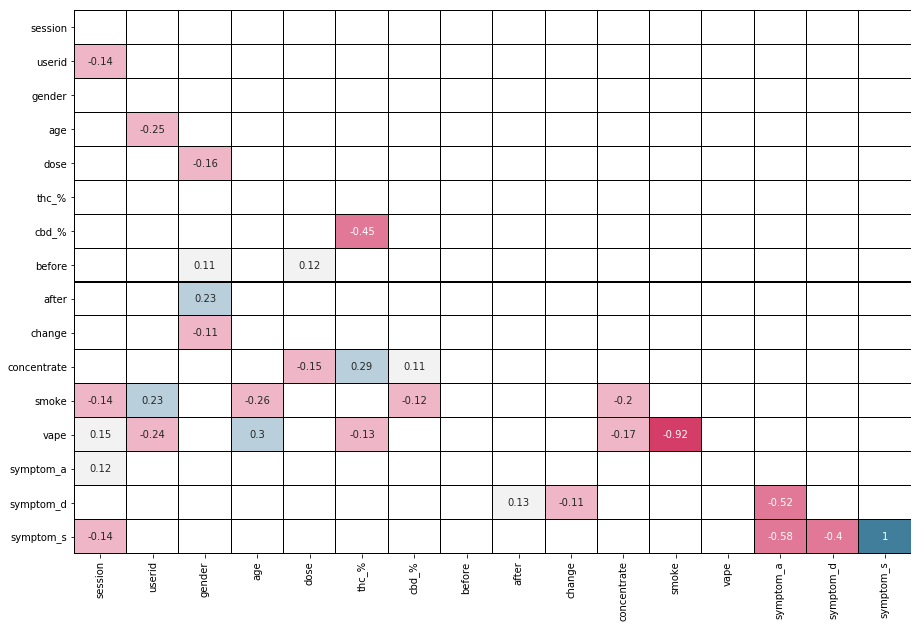

In [13]:
df_cor          = df.drop(['time_lag', 'dab_bubbler', 'dab_portable'],axis = 1).corr() 
# Dropped because nothing is signifigantly correlated to them
list_half_inner = []
list_half_outer = []

# Creating a blank-ish DF with the dementions that match the correlation matrix.
for i in range(df_cor.shape[0]):
    list_half_inner.append(True)
    list_half_outer.append(list_half_inner)
mask_half = pd.DataFrame(list_half_outer, columns= df_cor.columns, index=df_cor.columns)

# Turning it into a mask and cutting it in half.
for num in range(mask_half.shape[1]):
    mask_half.iloc[num,num:mask_half.shape[1]] = False

# Manually dropping certain values because they don't tell us anything by being correlated.
mask_half.loc['after','before'] = False
mask_half.loc['change','before':'after'] = False 

mask_half.iloc[df_cor.shape[0] - 1,df_cor.shape[1] - 1] = True
    
# Mask for limiting which correlations are shown.
mask_cor_limit = (df_cor > 0.1) | (df_cor < -0.1)
plt.figure(figsize=(15,10))

sns.heatmap(df_cor[mask_cor_limit][mask_half],
            annot = True, cbar=False, 
            linewidths= .01, linecolor='black', cmap=sns.diverging_palette(0, 230, n=7, center='light'));

# Modeling (1st Round)

### To Do Notes:
 - Tactics skipped or dropped:
     - Nieve Bayes (Tried and wasn't very effective.)
     - PCA (Not needed.  We have too few features and can intuit which ones should be dropped.)
     - Ada (Not very effective and not my wheelhouse.)
     - Extra Trees (Random Forest functioned better.  This points to a potential prefrence for bagging and thus altering the ratio of certain data and/or the random splits of Extra Trees proved ueless for this data.)
     
 - Tactics attempted and kept because of interest:
     - Attaching simpler models to Neural Network. (It's possible that I didn't do this well enough, yet.)
     - Poly features.  Ehh?

## Standard Regression Models

## Linear Regression

In [15]:
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df['after']

print('Linear Regression with all features.\n')
df_results = run_model(LinearRegression(), X, y, df_results)

Linear Regression with all features.

LinearRegression Train
RMSE             : 1.8705511257397889
Median Abs Error : 1.1547188257439125
R Squared        : 0.24273286952240758

LinearRegression Test
RMSE             : 1.7871879984833923
Median Abs Error : 1.086767293707859
R Squared        : 0.2776481708245998


The following is a Linear Regression with mostly just the "before" feature. ("symptom_a" is also included to keep X two dementional.


In [16]:
X = df[['before', 'symptom_a']]
y = df['after']

df_results = run_model(LinearRegression(), X, y, df_results)

Linear Regression with mostly just the "before" feature. ("symptom_a" is also included to keep X 2 dementional.)

LinearRegression Train
RMSE             : 1.9593148202169874
Median Abs Error : 1.240961972997948
R Squared        : 0.16915810450086066

LinearRegression Test
RMSE             : 1.8639998532131978
Median Abs Error : 1.1966323499042886
R Squared        : 0.2142216736065744


As far as linear regression is concerned, the most important value in our data is how somebody was feeling before attempting to medicate with cannabis.

## Gaussian Nieve Bayes
(Wanted to test this out just because I've never gotten a chance to.  Results aren't horrible, but also are the worst of all I've tried.)

In [17]:
X = df[['before', 'userid']]
y = df['after']

df_results = run_model(GaussianNB(), X, y, df_results)

GaussianNB Train
RMSE             : 2.1989663708567675
Median Abs Error : 1.0
R Squared        : -0.04651899686761807

GaussianNB Test
RMSE             : 2.11883732107174
Median Abs Error : 1.0
R Squared        : -0.015321367609727243


## Random Forest & XGB

of the models I tried the one with the best consistent results was the Random Forrest Regressor.  I've also kept Linear Regression (it might provide insights and it's a coonsistent baseline) and XGBoost (I've always heard of how impressive XGB is and would like to use this opportunity to try it out.
Those I tried and deleted because they were redundant include:
Of the models tested these are the ones that I've tried and kept.  Most others were inferior versions of these three.

In [145]:
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'smoke', 'vape', 'symptom_d']]
y = df['after']
df_results = run_model(RandomForestRegressor(), X, y, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X, y, df_results)

KNeighborsRegressor Train
RMSE             : 1.341178562461761
Median Abs Error : 0.7999999999999998
R Squared        : 0.6068019652078811

KNeighborsRegressor Test
RMSE             : 1.6574925034660353
Median Abs Error : 0.8000000000000007
R Squared        : 0.39731495915612836
-------------------------------------
RandomForestRegressor Train
RMSE             : 0.6705246928024168
Median Abs Error : 0.30000000000000004
R Squared        : 0.9017194260067376

RandomForestRegressor Test
RMSE             : 1.5253364613874818
Median Abs Error : 0.8999999999999999
R Squared        : 0.48959071081158556
-------------------------------------
XGBRegressor Train
RMSE             : 1.5666734603560297
Median Abs Error : 0.9591712951660156
R Squared        : 0.4634686471989562

XGBRegressor Test
RMSE             : 1.5697987232273956
Median Abs Error : 0.9341617226600647
R Squared        : 0.45940103562082435


In [365]:

X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'smoke', 'vape', 'symptom_d', 'symptom_s']]
y = df['after']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.25, random_state=42)
df_results = run_model(RandomForestRegressor(),X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X_train, X_test, y_train, y_test, df_results)

RandomForestRegressor Train
RMSE : 0.666625263685198

RandomForestRegressor Test
RMSE : 1.5208670441487457
-------------------------------------
XGBRegressor Train
RMSE : 1.5690044593827843

XGBRegressor Test
RMSE : 1.5865567349202634


As Random Forrest gives the best test RMSE score, I'm going to be gridsearching on that.
The other benefit of going with Random Forrest is that I hope to one day digure out a consistent way to pull the actual diagram of the trees.  As such, in the future, I'll be able to get insights from the model where as going forward with the Gradient Boosting Regressor (or even using an XG Boost) would potentially result in a more accurate model, but the expected improvement would be less valuable to me than the potential future insights.

In [360]:
df_results.sort_values('test_RMSE').head(5)

,model,features,parameters,train_RMSE,train_Median_error,train_R_squared,test_RMSE,test_Median_error,test_R_squared,time
2,RandomForestRegressor,"[session, userid, gender, age, dose, time_lag,...","{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.643603,0.300000,0.909245,1.606832,0.900000,0.451058,"07/29/2019, 16:17:03"
3,GradientBoostingRegressor,"[session, userid, gender, age, dose, time_lag,...","{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",1.513857,0.918550,0.497885,1.638745,1.008785,0.429037,"07/29/2019, 16:17:04"
4,XGBRegressor,"[session, userid, gender, age, dose, time_lag,...","{'base_score': 0.5, 'booster': 'gbtree', 'cols...",1.517635,0.914063,0.495376,1.638757,0.998866,0.429029,"07/30/2019, 21:47:56"
1,KNeighborsRegressor,"[session, userid, gender, age, dose, time_lag,...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...",1.294884,0.800000,0.632638,1.676582,0.800000,0.402367,"07/29/2019, 16:17:02"
0,LinearRegression,"[session, userid, gender, age, dose, time_lag,...","{'copy_X': True, 'fit_intercept': True, 'n_job...",1.799234,1.092375,0.290735,1.859850,1.134135,0.264571,"07/29/2019, 16:15:41"


## Gridsearching

In [642]:
# Last gridsearch after about 10 trials.
params = {
    'n_estimators'      : [100, 200, 300],
    'max_features'      : [4, 5, 6],
    'min_samples_split' : [5, 6, 7],
    'min_samples_leaf'  : [4, 5, 6]
}
grid_RForest = GridSearchCV(RandomForestRegressor(), params, cv=3, n_jobs= 3, verbose = 1)


df_results = run_model(grid_RForest, X, y, df_results)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   29.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 243 out of 243 | elapsed:  3.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor Train
RMSE             : 1.0646553196245105
Median Abs Error : 0.6095238606986888
R Squared        : 0.7546828007700239

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor Test
RMSE             : 1.4356791523803567
Median Abs Error : 0.821787493824258
R Squared        : 0.5338527932870046


In [650]:
grid_RForest.best_params_

{'max_features': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 7,
 'n_estimators': 300}

 - n_estimators = number of trees in the foreset
 - max_features = max number of features considered for splitting a node
 - max_depth = max number of levels in each decision tree
 - min_samples_split = min number of data points placed in a node before the node is split
 - min_samples_leaf = min number of data points allowed in a leaf node

# Neural Network

I also enjoy using Neural Networks, even if the problem isn't a traditional NN problem

In [599]:
model_NN = Sequential()

#model_NN.add(LSTM(18))

model_NN.add(Dense(18,
          activation = 'relu',
          input_dim=18))
model_NN.add(Dense(15, activation = 'relu')) # Here, have another layer
#model_NN.add(Dense(10, activation = 'relu')) # Here, have another layer
#model_NN.add(Dense(5, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])




df_results = run_model(model_NN, pd.concat([X_train_modeled, X_test_modeled]), 
                       y, df_results, is_neural_network= True,
                       NN_epochs = 50, 
                       NN_batch_size = 128,
                       NN_verbose = 0)
#results = model_NN.fit(X_train_modeled, y_train_modeled, 
#                    epochs= 50,                               # Default is 1, but start with about 10
#                    batch_size = 128,
#                    validation_data = (X_test_modeled,y_test_modeled))

Neural Network Train
RMSE             : 2.1852978310697164
Median Abs Error : 1.3999885320663452
R Squared        : -0.03354933124007431

Neural Network Test
RMSE             : 2.1527748303353578
Median Abs Error : 1.2984983921051025
R Squared        : -0.04810673667576393


In [590]:
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df['after']

model_NN = Sequential()
model_NN.add(Dense(15,
          activation = 'relu',
          input_dim=X.shape[1]))             # Shape Error?  Check on this.
model_NN.add(Dense(10, activation = 'relu'))
model_NN.add(Dense(5, activation = 'relu'))
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])

df_results = run_model(model_NN, X, y, df_results, is_neural_network= True,
                       NN_epochs = 50, 
                       NN_batch_size = 64,
                       NN_verbose = 0)

Neural Network Train
RMSE             : 1.8603711584085985
Median Abs Error : 1.1451724171638489
R Squared        : 0.25095288296731966

Neural Network Test
RMSE             : 1.7963257816142286
Median Abs Error : 1.0893514156341553
R Squared        : 0.2702426053905985


In [125]:
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df['after']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.25, random_state=42)

In [97]:
model_NN = Sequential()
model_NN.add(Dense(1,
          activation = 'relu',
          input_dim=X_train.shape[1]))
model_NN.add(Dense(10, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(5, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])
results = model_NN.fit(X_train, y_train, 
                    epochs= 50,                               # Default is 1, but start with about 10
                    batch_size = 128,
                    validation_data = (X_test,y_test))

Train on 7509 samples, validate on 2504 samples
Epoch 1/50
7509/7509 [==============================] - 1s 137us/step - loss: 4509.6063 - rmse: 17.6258 - val_loss: 17.8742 - val_rmse: 3.5545
Epoch 2/50
7509/7509 [==============================] - 0s 57us/step - loss: 17.4299 - rmse: 3.5326 - val_loss: 17.3482 - val_rmse: 3.5252
Epoch 3/50
7509/7509 [==============================] - 0s 58us/step - loss: 16.9791 - rmse: 3.5011 - val_loss: 16.9535 - val_rmse: 3.4956
Epoch 4/50
7509/7509 [==============================] - 0s 53us/step - loss: 16.6277 - rmse: 3.4689 - val_loss: 16.5916 - val_rmse: 3.4639
Epoch 5/50
7509/7509 [==============================] - 0s 54us/step - loss: 16.3048 - rmse: 3.4353 - val_loss: 16.2030 - val_rmse: 3.4272
Epoch 6/50
7509/7509 [==============================] - 0s 56us/step - loss: 15.9686 - rmse: 3.3970 - val_loss: 15.8183 - val_rmse: 3.3864
Epoch 7/50
7509/7509 [==============================] - 0s 66us/step - loss: 15.6197 - rmse: 3.3553 - val_loss: 15

Text(0.5,0,'epochs')

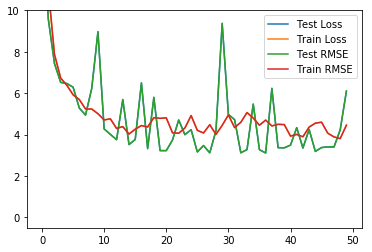

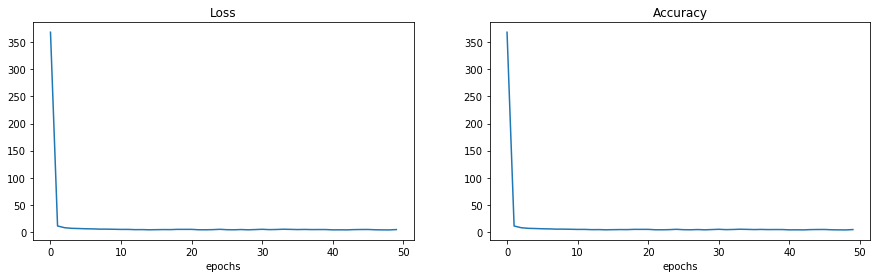

In [140]:
# Visualisations for classification Models
# Plots to view Loss/Accuracy over epoche's
axes = plt.gca()
#axes.set_xlim([-1,35])
axes.set_ylim([-0.5,10])
plt.plot(results.history['val_loss'], label='Test Loss')
plt.plot(results.history['loss'], label='Train Loss')
plt.legend();
plt.plot(results.history['val_mean_squared_error'], label='Test RMSE')
plt.plot(results.history["mean_squared_error"], label='Train RMSE')
plt.legend();

#Alternative
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,4))

ax[0].plot(results.history['loss'])
ax[0].set_title("Loss")
ax[0].set_xlabel("epochs")

ax[1].plot(results.history["mean_squared_error"])
ax[1].set_title("Accuracy")
ax[1].set_xlabel("epochs")

# Advanced Feature Engineering

## Stuff to be done
 - Sum of two features:
 - Difference between two features:
 - Product of two features:
 - Quotient of two features:
 - Aggregate observations/features: purchases_over_last_30_days
 - Numeric to categorical mappings/Binning/Label Encoding
 - Creating Feature via Trees w/sklearn_Tree_model.apply() or XGbooster.predict(pred_leaf = True)
 - from scipy.stats import rankdata? or Log Transformation: np.log(1 + x)

 - method * dose
 - change/error?

 - #df['amount_ingested'] = df['total_%']/df['dose'] or  (thc + cbd) * dose
 - Time lag @ about 20 minutes vs, before vs. after 25 minutes
 - High dose or low dose
 - Hypothetical effective dose. # print(1/ 80) #dose / age 10/18


 - validate via removing last observation of each userid 




 - Tactics to be tested:
     - Try Ordinal Logistic Regression Model
     - Also, create a proper scoring function for K-Folds when I have some spare time.  Not a high priority, tho.
     - Run a single Decision Tree and try again to get the visualization to work.



Error Analysis:
 - Start with larger errors: Error analysis is typically a manual process. You won’t have time to scrutinize every observation. We recommend starting with those that had higher error scores. Look for patterns that you can formalize into new features.
 - Segment by classes: Another technique is to segment your observations and compare the average error within each segment. You can try creating indicator variables for the segments with the highest errors.
 - Unsupervised clustering: If you have trouble spotting patterns, you can run an unsupervised clustering algorithm on the misclassified observations. We don’t recommend blindly using those clusters as a new feature, but they can make it easier to spot patterns. Remember, the goal is to understand why observations were misclassified.
 - Ask colleagues or domain experts:

# Attempting polynomial features

In [146]:
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'smoke', 'vape', 'symptom_d']]
X_poly = PolynomialFeatures().fit_transform(X)

y = df['after']

df_results = run_model(LinearRegression(), pd.DataFrame(X_poly), y, df_results)
print('')
df_results = run_model(RandomForestRegressor(), pd.DataFrame(X_poly), y, df_results)
print('')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), pd.DataFrame(X_poly), y, df_results)

LinearRegression Train
RMSE             : 1.7603926215834949
Median Abs Error : 1.1071200909461298
R Squared        : 0.32258125211441446

LinearRegression Test
RMSE             : 1.7261174255289677
Median Abs Error : 1.0870294132635139
R Squared        : 0.34637607570323037

RandomForestRegressor Train
RMSE             : 0.6740121189222796
Median Abs Error : 0.30000000000000004
R Squared        : 0.9006944449342817

RandomForestRegressor Test
RMSE             : 1.5539176252585047
Median Abs Error : 0.8999999999999999
R Squared        : 0.47028380389230473

XGBRegressor Train
RMSE             : 1.5248712260415493
Median Abs Error : 0.9400210976600647
R Squared        : 0.49171830270779626

XGBRegressor Test
RMSE             : 1.56533169423411
Median Abs Error : 0.9162205457687378
R Squared        : 0.46247332167333977


## Gridsearching Time Bins

In [191]:
list_o_dicts = []
for low in [15, 20, 25]:
    for mid in [19, 20, 40]:
        for high in [60, 90, 120]:
            def sorting(row):    
                if row['time_lag'] < low:
                    result = .1
                elif row['time_lag'] < mid:
                    result = .2
                elif row['time_lag'] < high:
                    result = .3
                else: 
                    result = .4
                return result
            df['binned_time'] = df.apply(sorting, axis=1)
            list_o_dicts.append({
                'low'  : low,
                'mid'  : mid,
                'high' : high,
                'corr' : df.corrwith(df['after'])['binned_time']
            })
df_grid = pd.DataFrame(list_o_dicts)

df_grid.sort_values('corr').head(10)

In [5]:
def sorting(row):    
    if row['time_lag'] < 15:
        result = .1
    elif row['time_lag'] < 19:
        result = .2
    elif row['time_lag'] < 120:
        result = .3
    else: 
        result = .4
    return result
df['binned_time'] = df.apply(sorting, axis=1)

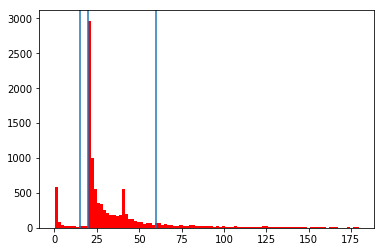

In [6]:
plt.axvline(x = 60)
plt.axvline(x = 15)
plt.axvline(x = 20)
plt.hist(df['time_lag'], bins = 100, color='red');

## Gridsearching Cannabis percentage classes

In [252]:
list_o_dicts = []
for slope_1 in [0, 0.01, 0.05]:
    for slope_2 in [0 , 5, 10]:
        def sorting(row):    
            if row['cbd_%'] < (row['thc_%'] * slope_1):
                result = 1
            elif row['cbd_%'] > (row['thc_%'] * slope_2):
                result = .5
            else: 
                result = 0
            return result
        df['strain_class'] = df.apply(sorting, axis=1)
        list_o_dicts.append({
            'slope_1'  : slope_1,
            'slope_2'  : slope_2,
            'corr' : np.abs(df.corrwith(df['after'])['strain_class'])
        })
df_grid = pd.DataFrame(list_o_dicts)

df_grid.sort_values('corr', ascending= False).tail(10)

,corr,slope_1,slope_2
1,0.010926,0.00,5
2,0.011165,0.00,10
5,0.012661,0.01,10
4,0.012728,0.01,5
3,0.014769,0.01,0
8,0.033108,0.05,10
7,0.033194,0.05,5
6,0.033301,0.05,0
0,0.055743,0.00,0


In [7]:
def sorting(row):    
    if row['cbd_%'] < (row['thc_%'] * 0.15):
        result = 1
    else: 
        result = 0
    return result
df['strain_class'] = df.apply(sorting, axis=1)

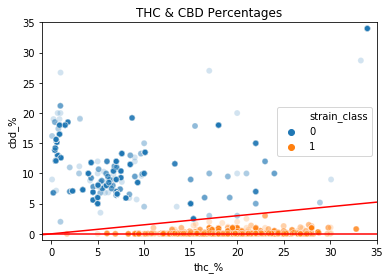

In [329]:
axes = plt.gca()
axes.set_xlim([-1,35])
axes.set_ylim([-1,35])
axes.set_title('THC & CBD Percentages')
sns.scatterplot(df['thc_%'],df['cbd_%'], hue = df['strain_class'], alpha=0.2);
x = np.linspace(-500,500)
y = 0.15*x
plt.plot(x, y, '-r');
x = np.linspace(-500,500)
y = 0*x
plt.plot(x, y, '-r');
#plt.legend(loc='upper left')
#plt.grid()

In [8]:
def sort(x):
    if x == 0:
        result = 0
    else:
        result = 1
    return result
df['has_cbd'] = df['cbd_%'].map(lambda x: sort(x))

Gridsearching Age Bins was attempted but resulted very very little correlation to continue down that path.

## Combining Dummies

In [9]:
# dd stands for "Double Dummies"
df['method_other'] = df['concentrate'] + df['dab_bubbler'] + df['dab_portable']
df['dd_gender_vape']  = df['gender'] * df['vape']
df['dd_gender_smoke'] = df['gender'] * df['smoke']
df['dd_gender_other'] = df['gender'] * df['method_other']
df['dd_gender_symptom_a'] = df['gender'] * df['symptom_a']
df['dd_gender_symptom_d'] = df['gender'] * df['symptom_d']
df['dd_sym_a_vape']  = df['symptom_a'] * df['vape'] 
df['dd_sym_d_vape']  = df['symptom_d'] * df['vape'] 
df['dd_sym_a_smoke'] = df['symptom_a'] * df['smoke']
df['dd_sym_d_smoke'] = df['symptom_d'] * df['smoke']
df['dd_sym_a_other'] = df['symptom_a'] * df['method_other']
df['dd_sym_d_other'] = df['symptom_d'] * df['method_other']
df['dd_sym_a_before'] = df['symptom_a'] * df['before']
df['dd_sym_d_before'] = df['symptom_d'] * df['before']

# td stands for "Triple Dummies"
df['td_sym_a_gender_before'] = df['gender'] * df['dd_sym_a_before']
df['td_sym_d_gender_before'] = df['gender'] * df['dd_sym_d_before']

## Other Engineered Features

In [10]:
df['total_%'] = (df['thc_%'] + df['cbd_%'])

df['strain_ratio'] = (df['thc_%'] - df['cbd_%'])/(df['thc_%'] + df['cbd_%'])

df.drop(['concentrate', 'dab_bubbler','dab_portable', 'symptom_a', 
         'symptom', 'method'], axis = 1, inplace = True)

In [149]:
list_last_session_indexes = []
list_ids = [i for i in df['userid'].unique()]
for i in list_ids:
    mask = df['userid'] == i
    list_last_session_indexes.append(df[mask]['session'].argmax())

df_test  = df.loc[list_last_session_indexes].drop('change', axis = 1)
df_train = df.drop(list_last_session_indexes).drop('change', axis = 1)

# Modeling (2nd Round)

In [14]:
X = df_train.drop(['after', 'change'], axis = 1)
y = df_train['after']

df_results = run_model(LinearRegression(), X, y, df_results)

LinearRegression Train
RMSE             : 1.799234041981743
Median Abs Error : 1.0923754506124834
R Squared        : 0.2907349159972833

LinearRegression Test
RMSE             : 1.8598498962807615
Median Abs Error : 1.1341352688571922
R Squared        : 0.26457075591130474


In [15]:
from xgboost import XGBRegressor
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X, y, df_results)

[17:22:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor Train
RMSE             : 1.5176347057456474
Median Abs Error : 0.9140629768371582
R Squared        : 0.49537616364081705

XGBRegressor Test
RMSE             : 1.6387567880699916
Median Abs Error : 0.9988656044006348
R Squared        : 0.4290289180257313


In [354]:
df_results = run_model(RandomForestRegressor(), X, y, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(), X, y, df_results)

KNeighborsRegressor Train
RMSE             : 1.2948835655679696
Median Abs Error : 0.7999999999999998
R Squared        : 0.6326376034078737

KNeighborsRegressor Test
RMSE             : 1.676582379793127
Median Abs Error : 0.8000000000000007
R Squared        : 0.40236654496067026
-------------------------------------
RandomForestRegressor Train
RMSE             : 0.6436027962373567
Median Abs Error : 0.3
R Squared        : 0.9092453039957278

RandomForestRegressor Test
RMSE             : 1.6068323690123159
Median Abs Error : 0.8999999999999999
R Squared        : 0.45105826648007397
-------------------------------------
GradientBoostingRegressor Train
RMSE             : 1.5138570717426727
Median Abs Error : 0.9185495646760309
R Squared        : 0.49788521490802395

GradientBoostingRegressor Test
RMSE             : 1.6387447018002923
Median Abs Error : 1.008784617010361
R Squared        : 0.42903734012361605


In [17]:

#[X[col] for col in X.columns]\

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            10050, 10052, 10053, 10054, 10055, 10056, 10057, 10059, 10062,
            10063],
           dtype='int64', length=9002)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 76)

In [31]:
from sklearn.preprocessing import StandardScaler#, PolynomialFeatures, MinMaxScaler, Normalizer#, Binarizer
X = StandardScaler().fit_transform(X)
#X = MinMaxScaler().fit_transform(X)
#X = Normalizer().fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 76)

In [43]:
from keras.layers import Flatten

In [128]:
model_NN = Sequential()
model_NN.add(LSTM(34,# input_shape = (6751, 34), 
                  return_sequences=True))
model_NN.add(Flatten())
model_NN.add(Dense(34, activation = 'relu'))#,
#          input_dim=X.shape[1]))             # Shape Error?  Check on this.

model_NN.add(Dense(30, activation = 'relu'))
model_NN.add(Dense(25, activation = 'relu'))
model_NN.add(Dense(20, activation = 'relu'))
model_NN.add(Dense(15, activation = 'relu'))
model_NN.add(Dense(10, activation = 'relu'))
model_NN.add(Dense(5, activation = 'relu'))

model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 76)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#[np.array(X_train.loc[i]) for i in X_train.index]
X_test  = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#[np.array(X_test.loc[i]) for i in X_test.index]
results = model_NN.fit(X_train, np.array(y_train),
            epochs= 50, 
            batch_size = 128,
            verbose = 0,
            validation_data = (X_test,np.array(y_test)))
#df_results = run_model(model_NN, X, y, df_results, is_neural_network= True,
#                       NN_epochs = 50, 
#                       NN_batch_size = 64,
#                       NN_verbose = 1)

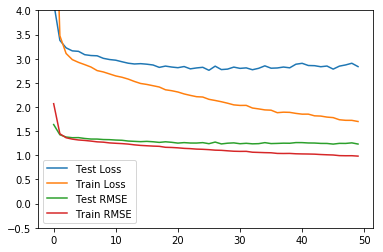

In [129]:
axes = plt.subplot()# = (10,10))
#axes.set_xlim([-1,35])
axes.set_ylim([-0.5,4])
plt.plot(results.history['val_loss'], label='Test Loss')
plt.plot(results.history['loss'], label='Train Loss')
plt.legend();
plt.plot(results.history['val_rmse'], label='Test RMSE')
plt.plot(results.history["rmse"], label='Train RMSE')
plt.legend();

In [130]:
pred_train = model_NN.predict(X_train)
pred_test  = model_NN.predict(X_test)

#model_NN.predict(np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])))

dict_model = {'model' : "Neural Network"}
dict_model['time']               = datetime.fromtimestamp(time()).strftime('%m/%d/%Y, %H:%M:%S')
dict_model['train_RMSE']         = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
dict_model['train_Median_error'] = metrics.median_absolute_error(y_train, pred_train)
dict_model['train_R_squared']    = metrics.r2_score(y_train, pred_train)
dict_model['test_RMSE']          = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
dict_model['test_Median_error']  = metrics.median_absolute_error(y_test, pred_test)
dict_model['test_R_squared']     = metrics.r2_score(y_test, pred_test)

dict_model['test_RMSE']

1.6840367194540886

Through the making of the recurrent neural network I discovered why it's not used in situations like this.  The NN is looking for patters of what becomes before and after.  There aren't exactly patterns in this dataset.  Each observation is it's own set of numbers to represent a factor in the eventual result.  Usually one would give the NN astring of words or or numbers that either represent a statement or picture.  Shame that I can't use this for this problem, but now I'll be better prepared for when I return to my NLP projects.

In [393]:
np.array(X['smoke'])

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [374]:
test = [X[col].as_matrix() for col in X.columns]

In [376]:
test

[array([1, 1, 2, ..., 1, 1, 1], dtype=int64),
 array([  93,   97,   97, ..., 5508, 5560, 5578], dtype=int64),
 array([0, 1, 1, ..., 1, 1, 1], dtype=int64),
 array([25, 46, 46, ..., 33, 24, 19], dtype=int64),
 array([ 4,  3,  3, ...,  4,  3, 10], dtype=int64),
 array([ 0.2,  0.4, 20.9, ..., 27.9, 67.8, 24.9]),
 array([ 6.14, 15.9 , 19.9 , ..., 19.5 , 16.5 , 19.  ]),
 array([6.85, 0.  , 0.1 , ..., 0.07, 0.2 , 0.5 ]),
 array([ 6,  6,  6, ...,  2,  6, 10], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 array([0.1, 0.1, 0.3, ..., 0.3, 0.3, 0.3]),
 array([0, 1, 1, ..., 1, 1, 1], dtype=int64),
 array([1, 0, 1, ..., 1, 1, 1], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0,

# Poly Features, Scaling & PCA

In [ ]:
pca = PCA()
pca = pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [54]:
pca = PCA(n_components= 3, svd_solver='auto')
X = pca.fit_transform(X)

In [56]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative explained variance: ', cum_var_exp)

Cumulative explained variance:  [0.99904023 0.99952489 0.99986689]


In [32]:
X = PolynomialFeatures().fit_transform(X)

In [59]:
df_results = run_model(RandomForestRegressor(), pd.DataFrame(X), y, df_results)

RandomForestRegressor Train
RMSE             : 0.711620928249017
Median Abs Error : 0.30000000000000004
R Squared        : 0.8904008049074752

RandomForestRegressor Test
RMSE             : 1.7017822343480467
Median Abs Error : 1.0
R Squared        : 0.34503775010259563


AFTER GETTING TO A MODELING PLATEAU I decided to do some research by a.) asking the question "how d people win Kaggle competitions"? and the second was looking into the actual study for ideas and thoughts about what was correlated with what.
Results of feature modeling:
    tried things and checked with correlations, and realized that I could essentially gridsearch potential lines and limits for potential features.
    When I ran models with these features my results, in many cases simply became overly fit, but didn't actually improve the Tes RMSE score ad in some cases made it worse.
    What I've always worried about feature engineering with features that are ust altered versions of other features is that I don't see how they're not just taking the same bite of prediction modeling as the previous un-edited features.  Unfortunatly this expierence has helped to reinforce this mindset and I'm unsure if I'm just doing something wrong or if this was simply ot going to work with the means I've gone through
    
Now I'm going to be trying the next following steps:
 - XGBoost
 - Creating Feature via Trees w/sklearn_Tree_model.apply() or XGbooster.predict(pred_leaf = True)
 - Fancy NN-esque Feature Creation.
 - Error Analysis
 - RNN????

If my puny human brain cannot find the answer then maybe the code can.


In [167]:
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test.drop('after', axis = 1)
y_test  = df_test['after']

In [168]:
df_results = run_model(LinearRegression(),X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X_train, X_test, y_train, y_test, df_results)

LinearRegression Train
RMSE             : 1.8134273928203657
Median Abs Error : 1.1062311301303276
R Squared        : 0.2849555427867543

LinearRegression Test
RMSE             : 1.9294457284354103
Median Abs Error : 1.2044274084301145
R Squared        : 0.14133653841556548
-------------------------------------
RandomForestRegressor Train
RMSE             : 0.6465364113951511
Median Abs Error : 0.3
R Squared        : 0.9091094612350193

RandomForestRegressor Test
RMSE             : 1.8751371575697289
Median Abs Error : 1.1
R Squared        : 0.1889942596845965
-------------------------------------
XGBRegressor Train
RMSE             : 1.5353667765760253
Median Abs Error : 0.9291240572929382
R Squared        : 0.48742552133676764

XGBRegressor Test
RMSE             : 1.8517394246969103
Median Abs Error : 1.1389299035072327
R Squared        : 0.20910724969749228


Across the board it's worse than just pulling random samples.  This is unfortunate for my hopes of getting the RMSE score down, but I don't regret putting in the work to represent 

In [169]:
mask = df_test['session'] > 1
df_test_without_newbies = df_test[mask]

In [170]:
print(df_train.shape)
print(df_test_without_newbies.shape)

(9002, 35)
(647, 35)


In [171]:
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(LinearRegression(),X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X_train, X_test, y_train, y_test, df_results)

LinearRegression Train
RMSE             : 1.8134273928203657
Median Abs Error : 1.1062311301303276
R Squared        : 0.2849555427867543

LinearRegression Test
RMSE             : 1.8835907910500216
Median Abs Error : 1.1902547817697147
R Squared        : 0.1736003940245382
-------------------------------------
RandomForestRegressor Train
RMSE             : 0.6353251769185382
Median Abs Error : 0.3
R Squared        : 0.9122342975323697

RandomForestRegressor Test
RMSE             : 1.7379392298395093
Median Abs Error : 1.0
R Squared        : 0.29646427180360346
-------------------------------------
XGBRegressor Train
RMSE             : 1.5353667765760253
Median Abs Error : 0.9291240572929382
R Squared        : 0.48742552133676764

XGBRegressor Test
RMSE             : 1.7805720807690955
Median Abs Error : 1.090909719467163
R Squared        : 0.2615244801045442


In [ ]:
Hmm.  While it's still not enough in range of the baseline, it IS better than with those for whome it's only been thier first time.

In [174]:
df_test['session'].value_counts()

1      415
2      165
3       94
4       58
5       57
6       32
7       31
9       25
8       17
10      16
12      14
13      13
14      12
18       7
19       7
16       6
15       6
11       5
21       5
20       4
39       4
17       3
51       3
50       3
22       3
25       3
27       3
29       3
31       3
32       2
      ... 
70       2
52       2
35       2
41       2
111      2
55       2
48       2
71       1
75       1
77       1
33       1
90       1
69       1
97       1
123      1
150      1
93       1
59       1
63       1
60       1
155      1
58       1
53       1
49       1
45       1
44       1
24       1
40       1
36       1
196      1
Name: session, Length: 63, dtype: int64

In [172]:
mask = df_test['session'] > 5
df_test_without_newbies = df_test[mask]
print(df_test_without_newbies.shape)
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(LinearRegression(),X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X_train, X_test, y_train, y_test, df_results)

(273, 35)
LinearRegression Train
RMSE             : 1.8134273928203657
Median Abs Error : 1.1062311301303276
R Squared        : 0.2849555427867543

LinearRegression Test
RMSE             : 1.895687682615924
Median Abs Error : 1.2366607504476015
R Squared        : 0.1782648415051924
-------------------------------------
RandomForestRegressor Train
RMSE             : 0.6327540547841728
Median Abs Error : 0.2999999999999998
R Squared        : 0.9129432249910328

RandomForestRegressor Test
RMSE             : 1.512826721288558
Median Abs Error : 1.0
R Squared        : 0.47666875299142153
-------------------------------------
XGBRegressor Train
RMSE             : 1.5353667765760253
Median Abs Error : 0.9291240572929382
R Squared        : 0.48742552133676764

XGBRegressor Test
RMSE             : 1.6949478415284043
Median Abs Error : 1.1571881771087646
R Squared        : 0.3430822919588644


In [175]:
mask = df_test['session'] > 10
df_test_without_newbies = df_test[mask]
print(df_test_without_newbies.shape)
X_train = df_train.drop('after', axis = 1)
y_train = df_train['after']
X_test  = df_test_without_newbies.drop('after', axis = 1)
y_test  = df_test_without_newbies['after']
df_results = run_model(LinearRegression(),X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X_train, X_test, y_train, y_test, df_results)

(152, 35)
LinearRegression Train
RMSE             : 1.8134273928203657
Median Abs Error : 1.1062311301303276
R Squared        : 0.2849555427867543

LinearRegression Test
RMSE             : 1.8846045649020937
Median Abs Error : 1.1288714268594755
R Squared        : 0.18704903117480876
-------------------------------------
RandomForestRegressor Train
RMSE             : 0.6335733904272991
Median Abs Error : 0.29999999999999993
R Squared        : 0.9127176242256524

RandomForestRegressor Test
RMSE             : 1.5841733690344295
Median Abs Error : 0.9000000000000001
R Squared        : 0.425580344759263
-------------------------------------
XGBRegressor Train
RMSE             : 1.5353667765760253
Median Abs Error : 0.9291240572929382
R Squared        : 0.48742552133676764

XGBRegressor Test
RMSE             : 1.6544984965669634
Median Abs Error : 1.1460312604904175
R Squared        : 0.37344870896682514


# Error Analysis

Okay.  It's finally time to attempt some Error Analysis.  Then I'll run my models one last time before gridsearching Random Forrest and XGB for my final run of models. 

In [180]:
df.drop(['dd_gender_vape', 'dd_gender_smoke', 'dd_gender_other',
       'dd_gender_symptom_a', 'dd_gender_symptom_d', 'dd_sym_a_vape',
       'dd_sym_d_vape', 'dd_sym_a_smoke', 'dd_sym_d_smoke', 'dd_sym_a_other',
       'dd_sym_d_other', 'dd_sym_a_before', 'dd_sym_d_before',
       'td_sym_a_gender_before', 'td_sym_d_gender_before'], axis = 1, inplace = True)

These features never seemed to add anything and wont tell my any new information, thus I'm dropping them.

In [182]:
df_results = run_model(LinearRegression(),X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X_train, X_test, y_train, y_test, df_results)

LinearRegression Train
RMSE : 1.8134273928203657

LinearRegression Test
RMSE : 1.8846045649020937
-------------------------------------
RandomForestRegressor Train
RMSE : 0.6361071481538778

RandomForestRegressor Test
RMSE : 1.565940948002695
-------------------------------------
XGBRegressor Train
RMSE : 1.5353667765760253

XGBRegressor Test
RMSE : 1.6544984965669634


In [301]:
df = df.drop(['y_lin','y_rfr','y_xgb',#'err_lin','err_rfr','err_xgb'#, 'y_log'
             ], axis = 1)

X = df.drop(['after', 'change'], axis = 1)
y = df['after']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)
df['y_lin'] = np.round(LinearRegression().fit(X_train, y_train).predict(X))
df['y_rfr'] = RandomForestRegressor().fit(X_train, y_train).predict(X)
df['y_xgb'] = np.round(XGBRegressor(objective='reg:squarederror').fit(X_train, y_train).predict(X))

print(np.sqrt(metrics.mean_squared_error(df['after'], df['y_lin'])))
print(np.sqrt(metrics.mean_squared_error(df['after'], df['y_rfr'])))
print(np.sqrt(metrics.mean_squared_error(df['after'], df['y_xgb'])))

1.8650571028309963
0.9753770010194248
1.5939073186796466


In [311]:
df = df.drop([#'y_lin','y_rfr','y_xgb',
              'binned_time','strain_class','has_cbd','method_other','total_%','strain_ratio'
              #'err_lin','err_rfr','err_xgb'#, 'y_log'
             ], axis = 1)

In [315]:
df

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,after,change,smoke,vape,symptom_d,symptom_s
0,1,93,0,25,4,0.2,6.14,6.85,6,2,4,0,1,1,0
1,1,97,1,46,3,0.4,15.90,0.00,6,1,5,0,1,1,0
2,2,97,1,46,3,20.9,19.90,0.10,6,1,5,0,1,1,0
3,3,97,1,46,3,22.3,4.50,6.90,8,0,8,0,1,1,0
4,4,97,1,46,3,21.7,14.60,0.04,7,0,7,0,1,1,0
5,5,97,1,46,3,20.8,17.70,0.05,6,0,6,0,1,1,0
6,6,97,1,46,3,21.3,8.50,11.50,6,0,6,0,1,1,0
7,7,97,1,46,2,20.8,4.50,6.90,8,1,7,0,1,1,0
8,8,97,1,46,3,28.1,14.60,0.04,6,0,6,0,1,1,0
9,9,97,1,46,3,21.0,17.50,0.00,9,0,9,0,1,1,0


In [334]:
X

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,smoke,vape,symptom_d,symptom_s,binned_time,strain_class,has_cbd,method_other,total_%,strain_ratio
0,1,93,0,25,4,0.2,6.14,6.85,6,0,1,1,0,0.1,0,1,0,12.99,-0.054657
1,1,97,1,46,3,0.4,15.90,0.00,6,0,1,1,0,0.1,1,0,0,15.90,1.000000
2,2,97,1,46,3,20.9,19.90,0.10,6,0,1,1,0,0.3,1,1,0,20.00,0.990000
3,3,97,1,46,3,22.3,4.50,6.90,8,0,1,1,0,0.3,0,1,0,11.40,-0.210526
4,4,97,1,46,3,21.7,14.60,0.04,7,0,1,1,0,0.3,1,1,0,14.64,0.994536
5,5,97,1,46,3,20.8,17.70,0.05,6,0,1,1,0,0.3,1,1,0,17.75,0.994366
6,6,97,1,46,3,21.3,8.50,11.50,6,0,1,1,0,0.3,0,1,0,20.00,-0.150000
7,7,97,1,46,2,20.8,4.50,6.90,8,0,1,1,0,0.3,0,1,0,11.40,-0.210526
8,8,97,1,46,3,28.1,14.60,0.04,6,0,1,1,0,0.3,1,1,0,14.64,0.994536
9,9,97,1,46,3,21.0,17.50,0.00,9,0,1,1,0,0.3,1,0,0,17.50,1.000000


In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

In [336]:
X_train

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,smoke,vape,symptom_d,symptom_s,binned_time,strain_class,has_cbd,method_other,total_%,strain_ratio
7483,24,1228,1,26,2,42.0,22.60,0.00,6,1,0,0,1,0.3,1,0,0,22.60,1.000000
1739,14,3237,0,38,10,28.7,18.50,0.00,8,1,0,1,0,0.3,1,0,0,18.50,1.000000
7732,69,1559,0,41,6,20.7,17.30,0.06,6,0,1,0,1,0.3,1,1,0,17.36,0.993088
7371,7,1055,0,36,10,25.1,20.10,0.07,5,1,0,0,1,0.3,1,1,0,20.17,0.993059
9287,13,3641,0,22,2,61.9,21.00,0.00,4,1,0,0,1,0.3,1,0,0,21.00,1.000000
1905,15,3499,1,22,6,20.2,20.00,0.50,4,1,0,1,0,0.3,1,1,0,20.50,0.951220
1010,99,2323,1,45,6,20.5,0.90,18.00,4,0,1,1,0,0.3,0,1,0,18.90,-0.904762
877,2,2238,1,19,3,20.7,19.00,0.00,7,1,0,1,0,0.3,1,0,0,19.00,1.000000
9005,23,3237,0,38,10,43.2,18.50,0.00,9,1,0,0,1,0.3,1,0,0,18.50,1.000000
1675,4,3117,1,32,10,49.5,14.95,0.12,5,0,1,1,0,0.3,1,1,0,15.07,0.984074


In [337]:
model = RandomForestRegressor()

print(np.sqrt(metrics.mean_squared_error(df['after'], model.fit(X_train, y_train).predict(X))))

0.9675652083619132


In [340]:
print(np.sqrt(metrics.mean_squared_error(df['after'], LinearRegression().fit(X_train, y_train).predict(X))))

1.8451819004311052


In [338]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [339]:
feature_importances

,importance
before,0.193554
userid,0.149291
age,0.132009
session,0.100769
time_lag,0.090128
total_%,0.061873
dose,0.053389
thc_%,0.050720
gender,0.039620
strain_ratio,0.035314


In [341]:
df['err_question'] = df['after'] - model.fit(X_train, y_train).predict(X)

print(metrics.accuracy_score(df['after'], df['y_lin']))
print(metrics.accuracy_score(df['after'], df['y_rfr']))
print(metrics.accuracy_score(df['after'], df['y_xgb']))

In [267]:
df.columns

Index(['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'after', 'change', 'smoke', 'vape', 'symptom_d',
       'symptom_s', 'binned_time', 'strain_class', 'has_cbd', 'method_other',
       'total_%', 'strain_ratio', 'y_lin', 'y_rfr', 'y_xgb', 'err_lin',
       'err_rfr', 'err_xgb'],
      dtype='object')

This cannot be right.  I must have done something wrong cause that's too accurate.

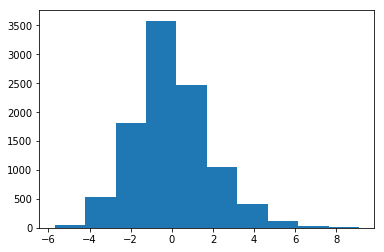

In [230]:
plt.hist(df['err_lin']);
#df['err_lin'].value_counts()

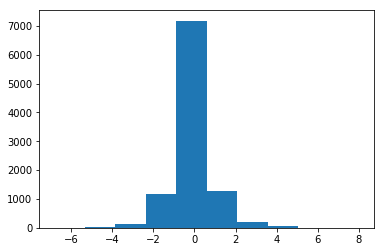

In [269]:
plt.hist(df['err_rfr']);
#df['err_rfr'].value_counts()

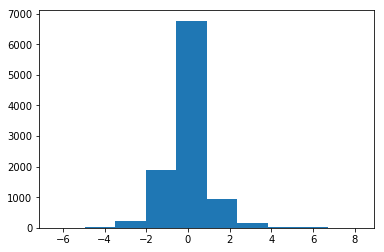

In [261]:
plt.hist(df['err_rfr']);
#df['err_rfr'].value_counts()

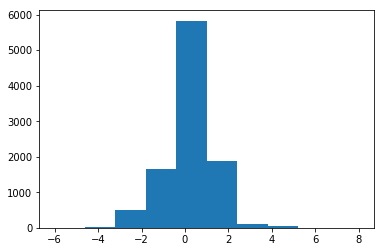

In [251]:
plt.hist(df['err_rfr']);
#df['err_rfr'].value_counts()

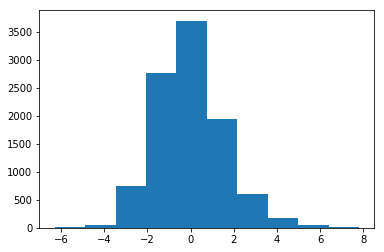

In [237]:
plt.hist(df['err_xgb']);
#df['err_xgb'].value_counts()

In [208]:
df[['after','y_lin','y_rfr','y_xgb']]

,after,y_lin,y_rfr,y_xgb
0,2,2.0,2.1,2.0
1,1,3.0,1.3,1.0
2,1,3.0,1.0,1.0
3,0,4.0,0.7,1.0
4,0,4.0,0.1,0.0
5,0,3.0,0.3,1.0
6,0,3.0,0.0,1.0
7,1,4.0,0.7,2.0
8,0,3.0,0.2,1.0
9,0,4.0,0.3,2.0


In [ ]:
from sklearn.preprocessing import StandardScaler#, PolynomialFeatures, MinMaxScaler, Normalizer#, Binarizer
#X = StandardScaler().fit_transform(X)
#X = MinMaxScaler().fit_transform(X)
#X = Normalizer().fit_transform(X)

In [345]:
X_train, X_test, y_train, y_test = train_test_split(Normalizer().fit_transform(X), y, random_state = 13)
df_results = run_model(LinearRegression(),X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(RandomForestRegressor(), X_train, X_test, y_train, y_test, df_results)
print('-------------------------------------')
df_results = run_model(XGBRegressor(objective='reg:squarederror'), X_train, X_test, y_train, y_test, df_results)

LinearRegression Train
RMSE : 2.084492531381542

LinearRegression Test
RMSE : 2.0672661494727906
-------------------------------------
RandomForestRegressor Train
RMSE : 0.6432355612692748

RandomForestRegressor Test
RMSE : 1.552859048389564
-------------------------------------
XGBRegressor Train
RMSE : 1.530357188074641

XGBRegressor Test
RMSE : 1.602684461501444


In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

print(np.sqrt(metrics.mean_squared_error(df['after'],model.fit(X_train, y_train).predict(X))))

0.9717655575740078


In [319]:
df

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,after,change,smoke,vape,symptom_d,symptom_s
0,1,93,0,25,4,0.2,6.14,6.85,6,2,4,0,1,1,0
1,1,97,1,46,3,0.4,15.90,0.00,6,1,5,0,1,1,0
2,2,97,1,46,3,20.9,19.90,0.10,6,1,5,0,1,1,0
3,3,97,1,46,3,22.3,4.50,6.90,8,0,8,0,1,1,0
4,4,97,1,46,3,21.7,14.60,0.04,7,0,7,0,1,1,0
5,5,97,1,46,3,20.8,17.70,0.05,6,0,6,0,1,1,0
6,6,97,1,46,3,21.3,8.50,11.50,6,0,6,0,1,1,0
7,7,97,1,46,2,20.8,4.50,6.90,8,1,7,0,1,1,0
8,8,97,1,46,3,28.1,14.60,0.04,6,0,6,0,1,1,0
9,9,97,1,46,3,21.0,17.50,0.00,9,0,9,0,1,1,0


In [348]:
test_df = pd.read_csv('./data/all_symptoms_cleaned.csv')

In [357]:
X = test_df.drop(['after','change','symptom', 'method'], axis = 1)
y = test_df['after']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

print(np.sqrt(metrics.mean_squared_error(df['after'],model.fit(X_train, y_train).predict(X))))

0.9813736276965643


In [356]:
X = test_df.drop(['after','change','concentrate','dab_bubbler','dab_portable','symptom_s','symptom', 'method'], axis = 1)
y = test_df['after']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

print(np.sqrt(metrics.mean_squared_error(df['after'],RandomForestRegressor().fit(X_train, y_train).predict(X))))

0.9824093747772557


In [389]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rando_state)
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'smoke', 'vape', 'symptom_d', 'symptom_s']]
y = df['after']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [403]:
def test_run(model, X_train, X_test, y_train, y_test):
    return np.sqrt(metrics.mean_squared_error(y_test, model.fit(X_train, y_train).predict(X_test)))
test_run(RandomForestRegressor(),X_train, X_test, y_train, y_test)

1.6440877842406556

In [404]:
PRED = RandomForestRegressor().fit(X_train, y_train).predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test,PRED)))

1.6032335171932468


Okay.  Finally figured out the problem.  Instead of scoring on just the test data, like one should, I fell into an accident of scoring the entirety of the full dataset after it had been trained on the majority of it.  While this made sense at the time for analyzing errors, it was silly to forget that this would squew the total score when Random Forrests already have a habbit of being overfit.
To avod this mistake I'm going to only be performing error analysis on the test data.

In [416]:
df_test.columns

Index(['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'after', 'smoke', 'vape', 'symptom_d', 'symptom_s',
       'binned_time', 'strain_class', 'has_cbd', 'method_other',
       'dd_gender_vape', 'dd_gender_smoke', 'dd_gender_other',
       'dd_gender_symptom_a', 'dd_gender_symptom_d', 'dd_sym_a_vape',
       'dd_sym_d_vape', 'dd_sym_a_smoke', 'dd_sym_d_smoke', 'dd_sym_a_other',
       'dd_sym_d_other', 'dd_sym_a_before', 'dd_sym_d_before',
       'td_sym_a_gender_before', 'td_sym_d_gender_before', 'total_%',
       'strain_ratio'],
      dtype='object')

In [417]:
# Creating & splitting dfs
df_test['symptom'] = df_['symptom']
df_test['method'] = df['method']
X = df_test.drop(['after'], axis = 1)
y = df_test['after']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

serie

series_sym = X_test['symptom']
series_met = X_test['method']
X_train.drop(['symptom', 'method'], axis = 1, inplace = True)
X_test.drop(['symptom', 'method'], axis = 1, inplace = True)
series_pred = RandomForestRegressor().fit(X_train, y_train).predict(X_test)

df_error = X_test.iloc[:,:]
df_error['prediction'] = predictions

KeyError: 'symptom'

In [407]:
df_error

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,smoke,vape,symptom_a,symptom_d,prediction
9863,5,4613,0,25,10,174.0,0.45,14.20,5,1,0,0,0,2.2
3773,12,1629,1,25,10,20.4,21.00,0.00,3,0,1,1,0,1.4
4277,13,2199,1,26,9,40.6,13.60,0.00,4,0,1,1,0,2.2
2030,27,3658,0,36,3,27.4,25.30,0.04,5,0,1,0,1,1.0
3641,6,1611,1,28,10,27.9,19.00,0.04,6,1,0,1,0,2.3
9121,3,3361,1,35,3,39.3,6.70,10.40,4,1,0,0,0,1.6
7313,1,1019,1,38,10,21.6,19.00,0.00,5,1,0,0,0,1.8
366,1,1509,0,22,10,78.5,13.59,0.00,4,1,0,0,1,1.4
635,67,1901,1,43,9,30.0,16.99,0.07,9,0,1,0,1,6.7
4278,14,2199,1,26,6,32.5,22.59,0.10,6,1,0,1,0,2.2


# XGB Gridsearching & Feature Extraction

In [ ]:
knn_params = {
    'n_neighbors':[9, 12, 15, 18 ,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
knn_gridsearch = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, verbose=1, n_jobs=2,)


df_results = run_model(knn_gridsearch, X, y, df_results)

# Code Recycling Bin

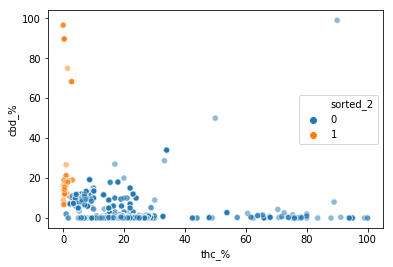

In [67]:
test_df = df[['thc_%', 'cbd_%']]
test_df['sorted_1'] = ((df['thc_%'] * 3/5) >= df['cbd_%']) * 1
test_df['sorted_2'] = ((df['thc_%'] * 5.5) <= df['cbd_%']) * 1
sns.scatterplot(test_df['thc_%'],test_df['cbd_%'],hue= test_df['sorted_2'],alpha=0.5);

# Feature Engineering
 - Sum of two features:
 - Difference between two features:
 - Product of two features:
 - Quotient of two features:
 - Aggregate observations/features: purchases_over_last_30_days
 - Numeric to categorical mappings:
 - Group into "Other" Category
 - Binning:
 - Label Encoding (Used for ordinal categorical features)
 - One-Hot Encode by two different features.
 - Creating Feature via Trees w/sklearn_Tree_model.apply() or XGbooster.predict(pred_leaf = True)
 - from scipy.stats import rankdata? or Log Transformation: np.log(1 + x)
 - thc + cbd
 - (thc + cbd) * dose
 - linear cut of thc & cbd percentages
 - otherize Concentrate, Dab_bubb;ler & dab_portable
 - before * gender * symptom
 - symptom * gender
 - method * dose
 - change/error?
 - bin ages
 - bin time_lag
 - #df['total_%'] = (df['thc_%'] + df['cbd_%'])
 - #df['amount_ingested'] = df['total_%']/df['dose']
 - #df.drop(['concentrate','dab_bubbler','dab_portable'])



validate via removing last thingy of each userid 
Representation Learning Features
Mean-Encoding: (For binary Categorical Prediction)


Error Analysis:
 - Start with larger errors: Error analysis is typically a manual process. You won’t have time to scrutinize every observation. We recommend starting with those that had higher error scores. Look for patterns that you can formalize into new features.
 - Segment by classes: Another technique is to segment your observations and compare the average error within each segment. You can try creating indicator variables for the segments with the highest errors.
 - Unsupervised clustering: If you have trouble spotting patterns, you can run an unsupervised clustering algorithm on the misclassified observations. We don’t recommend blindly using those clusters as a new feature, but they can make it easier to spot patterns. Remember, the goal is to understand why observations were misclassified.
 - Ask colleagues or domain experts:

In [ ]:
def f(row):    
    return row['cbd_%'] + row['thc_%'] 
df['total_%'] = df.apply(f, axis=1)

In [103]:
ss = StandardScaler()         
X_train_scaled = ss.fit_transform(X_train)  # Fit & Transform XTrain
X_test_scaled = ss.transform(X_test)        # Transform XTest

In [54]:
pca = PCA(n_components= 3, svd_solver='auto')
X = pca.fit_transform(X)

In [132]:
tdf_flame  = pd.read_csv('../../Unsupervised_learning/datasets/flame.csv')
tdf_agg    = pd.read_csv('../../Unsupervised_learning/datasets/aggregation.csv')
tdf_comp   = pd.read_csv('../../Unsupervised_learning/datasets/compound.csv')
tdf_jain   = pd.read_csv('../../Unsupervised_learning/datasets/jain.csv')
tdf_path   = pd.read_csv('../../Unsupervised_learning/datasets/pathbased.csv')
tdf_r15    = pd.read_csv('../../Unsupervised_learning/datasets/r15.csv')
tdf_spiral = pd.read_csv('../../Unsupervised_learning/datasets/spiral.csv')

In [136]:
test_df = tdf_path
test_X  = test_df[['x','y']]
test_y  = test_df['label']
#plt.figure(figsize = (5,5))
#plt.scatter(the_df['x'],the_df['y'], c = the_df['label'], alpha=0.7);

In [140]:
model_NN = Sequential()
#model_NN.add(LSTM(34,# input_shape = (6751, 34), return_sequences=True))
#model_NN.add(Flatten())
model_NN.add(Dense(2, activation = 'relu', input_dim=test_X.shape[1]))             # Shape Error?  Check on this.

#model_NN.add(Dense(5, activation = 'relu'))

model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])


X_train, X_test, y_train, y_test = train_test_split(test_X, test_y, random_state = 76)
results = model_NN.fit(X_train, y_train,
            epochs= 15, 
            batch_size = 16,
            verbose = 1,
            validation_data = (X_test, y_test))

Train on 225 samples, validate on 75 samples
Epoch 1/15
225/225 [==============================] - 3s 14ms/step - loss: 2.4893 - rmse: 1.3950 - val_loss: 2.8465 - val_rmse: 1.5288
Epoch 2/15
225/225 [==============================] - 0s 248us/step - loss: 2.4050 - rmse: 1.3844 - val_loss: 2.7384 - val_rmse: 1.5079
Epoch 3/15
225/225 [==============================] - 0s 328us/step - loss: 2.3314 - rmse: 1.3745 - val_loss: 2.6453 - val_rmse: 1.4885
Epoch 4/15
225/225 [==============================] - 0s 383us/step - loss: 2.2611 - rmse: 1.3586 - val_loss: 2.5769 - val_rmse: 1.4686
Epoch 5/15
225/225 [==============================] - 0s 338us/step - loss: 2.2029 - rmse: 1.3378 - val_loss: 2.5145 - val_rmse: 1.4489
Epoch 6/15
225/225 [==============================] - 0s 335us/step - loss: 2.1417 - rmse: 1.3239 - val_loss: 2.4397 - val_rmse: 1.4290
Epoch 7/15
225/225 [==============================] - 0s 386us/step - loss: 2.0807 - rmse: 1.3069 - val_loss: 2.3762 - val_rmse: 1.4104
Epoc

In [193]:
from sklearn.linear_model import LogisticRegression
y_log = LogisticRegression().fit(X_train, y_train).predict(X)
print('acry: ', metrics.accuracy_score(df['after'],y_log))
print('rmse: ', np.sqrt(metrics.mean_squared_error(df['after'],y_log)))

acry:  0.25457074721780604
rmse:  2.1690068280279333


While working at my sister's happy hour I had the good luck to get into a conversation with a nice guy who manages Data Scientists.  After explaining to him the data and my goal and my new super weird situation with the random forrest, he reminded me to normalize my data.
Goodness I feel silly for loosing mysef in the forrest and missing the trees.

He also advised that I get some pipeline softwear to make things easier.  A thing that I'll be looking into soon.
Big advice from Harrison: Get some pipeline softwear

1.) Log the params
put the 

in pipleing visualization function
CSV file of the parameters

Keep the baseline in mind.

In [250]:
df_results

,model,features,parameters,train_RMSE,train_Median_error,train_R_squared,test_RMSE,test_Median_error,test_R_squared,time
0,LinearRegression,"[session, userid, gender, age, dose, time_lag,...","{'copy_X': True, 'fit_intercept': True, 'n_job...",1.813427,NaN,NaN,1.884605,NaN,NaN,"08/02/2019, 19:19:30"
1,RandomForestRegressor,"[session, userid, gender, age, dose, time_lag,...","{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.636107,NaN,NaN,1.565941,NaN,NaN,"08/02/2019, 19:19:31"
2,XGBRegressor,"[session, userid, gender, age, dose, time_lag,...","{'base_score': 0.5, 'booster': 'gbtree', 'cols...",1.535367,NaN,NaN,1.654498,NaN,NaN,"08/02/2019, 19:19:33"
3,LinearRegression,"[session, userid, gender, age, dose, time_lag,...","{'copy_X': True, 'fit_intercept': True, 'n_job...",1.838510,NaN,NaN,1.830489,NaN,NaN,"08/02/2019, 20:45:40"
4,RandomForestRegressor,"[session, userid, gender, age, dose, time_lag,...","{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.656962,NaN,NaN,1.589354,NaN,NaN,"08/02/2019, 20:45:41"
5,XGBRegressor,"[session, userid, gender, age, dose, time_lag,...","{'base_score': 0.5, 'booster': 'gbtree', 'cols...",1.565119,NaN,NaN,1.615486,NaN,NaN,"08/02/2019, 20:45:41"
6,LinearRegression,"[session, userid, gender, age, dose, time_lag,...","{'copy_X': True, 'fit_intercept': True, 'n_job...",1.836571,NaN,NaN,1.826425,NaN,NaN,"08/02/2019, 20:52:07"
7,RandomForestRegressor,"[session, userid, gender, age, dose, time_lag,...","{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.660697,NaN,NaN,1.607031,NaN,NaN,"08/02/2019, 20:52:08"
8,XGBRegressor,"[session, userid, gender, age, dose, time_lag,...","{'base_score': 0.5, 'booster': 'gbtree', 'cols...",1.565119,NaN,NaN,1.615486,NaN,NaN,"08/02/2019, 20:52:10"
9,LinearRegression,"[session, userid, gender, age, dose, time_lag,...","{'copy_X': True, 'fit_intercept': True, 'n_job...",2.049553,NaN,NaN,2.027851,NaN,NaN,"08/02/2019, 20:52:10"


Full disclosure: I couldn't remember the pros/cons of the different and now didn't seem like the best time to invest the time to research that info, so I just tried the three I'm most familiar with and went with the one that gave the best result.